In [14]:
#math
import numpy as np
import scipy.stats as stats
import scipy.linalg as linalg
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [15]:
#generate the sample
def gen_data(beta1 = 5, beta2 = 6, alpha = 6):
    nobs = 1000
    x = np.random.uniform(low=0, high=1., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)# np.random.uniform(low=-1., high=1., size=nobs) # 
    y = alpha + beta1 * x + beta2*x**2  + e
    y = .001 + y*(y>=.0001) # ensure that we don't get negative ys...
    return y,x,nobs

In [16]:
def compute_loglike(resid):
    sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
    ll = np.log(stats.norm.pdf(resid,loc=0,scale=sigma))
    return ll

def compute_llr(yn,xn):
    
    model1 = sm.OLS(np.log(yn),sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = compute_loglike(np.exp(model1_fit.resid))
    
    model2 = sm.OLS(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    ll2 = compute_loglike(model2_fit.resid)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(49.27797784931772, 0.7206378061753169)


In [17]:
def compute_score(yn,xn,params,exp_resid=False):
    
    if exp_resid:
        yn = np.log(yn)
    
    xn = sm.add_constant(xn)
    resid = yn - np.matmul(xn,params)
    if exp_resid:
        resid = np.exp(resid)
    
    k = len(params)
    scale = (resid**2).mean()
    
    tile_resid = np.tile( resid, k)
    tile_resid = np.reshape(tile_resid, (k,xn.shape[0]) ).transpose()
    grad = tile_resid*xn/scale     
    return grad
    
def compute_hess(yn,xn,params):
    pass


def setup_shi(yn,xn):
    
    # model 1 grad, etc.
    model1 = sm.OLS(np.log(yn),sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    k1 = len(model1_fit.params)
    
    ll1 = compute_loglike(np.exp(model1_fit.resid))
    grad1 =  compute_score(yn,xn,model1_fit.params,exp_resid=True)    
    scale1 = (np.exp(model1_fit.resid)**2).mean()
    hess1 = model1.hessian(model1_fit.params,scale=2*scale1)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(xn))
    model2_fit = model2.fit(disp=False)
    k2 = len(model1_fit.params)
    
    ll2 = compute_loglike(model2_fit.resid)
    grad2 =  compute_score(yn,xn,model2_fit.params)
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

[[-0.08559879 -0.03553363]
 [-0.03553363 -0.04894919]]
[-1.79244823 -0.00344731  1.83095491  1.99950497]


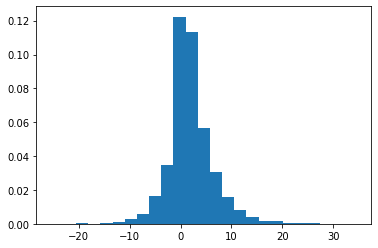

(80.80623218283836, 0.6397314322986765)


In [18]:
def compute_eigen(yn,xn):
    ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)
    hess1 = hess1/len(ll1)
    hess2 = hess2/len(ll2)
    
    k = k1 + k2
    n = len(ll1)
    
    #A_hat:
    A_hat1 = np.concatenate([hess1,np.zeros((k1,k2))])
    A_hat2 = np.concatenate([np.zeros((k2,k1)),-1*hess2])
    A_hat = np.concatenate([A_hat1,A_hat2],axis=1)

    #B_hat, covariance of the score...
    B_hat =  np.concatenate([grad1,-grad2],axis=1) #might be a mistake here..
    B_hat = np.cov(B_hat.transpose())
    print(B_hat[0:2,2:])
    
    #compute eigenvalues for weighted chisq
    sqrt_B_hat= linalg.sqrtm(B_hat)
    W_hat = np.matmul(sqrt_B_hat,linalg.inv(A_hat))
    W_hat = np.matmul(W_hat,sqrt_B_hat)
    V,W = np.linalg.eig(W_hat)
    print(V)
    return V

n_sims = 5000
yn,xn,nobs = gen_data()
model_eigs = compute_eigen(yn,xn)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()
print(compute_llr(yn,xn))

[[-0.04243852 -0.01321081]
 [-0.01321081 -0.04202527]]
[-1.43249611 -0.00892398  1.93536026  2.07732702]
[-1.43249611 -0.00892398  1.93536026  2.07732702]


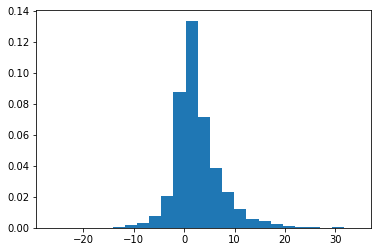

(559.7950189473693, 0.5780442940829911)


In [19]:
n_sims = 5000
yn,xn,nobs = gen_data(beta1 = 1, beta2 = 20, alpha = 6)
model_eigs = compute_eigen(yn,xn)
print(model_eigs)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()
print(compute_llr(yn,xn))

[[-0.11460202 -0.0512169 ]
 [-0.0512169  -0.03660939]]
[-1.93001658e+00 -8.05412337e-04  2.07996516e+00  1.97188792e+00]
[-1.93001658e+00 -8.05412337e-04  2.07996516e+00  1.97188792e+00]


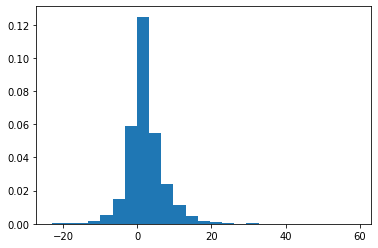

(-5.44058133540284, 0.688826097377045)


In [21]:
n_sims = 5000
yn,xn,nobs = gen_data(beta1 = 5, beta2 = 1, alpha = 6)
model_eigs = compute_eigen(yn,xn)
print(model_eigs)
eigs_tile = np.tile(model_eigs,n_sims).reshape(n_sims,len(model_eigs))
normal_draws = stats.norm.rvs(size=(n_sims,len(model_eigs)))
weighted_chi = ((normal_draws**2)*eigs_tile).sum(axis=1)
plt.hist(weighted_chi,density=True,bins=25)
plt.show()
print(compute_llr(yn,xn))